Set up the project and site url parameters

In [3]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np

load_dotenv()

# Get the API key from the environment
API_KEY = os.getenv("STEAM_API_KEY")
MARKET_API_KEY = os.getenv("STEAM_MARKET_API_KEY")

In [2]:
steam_store = "https://store.steampowered.com"
# /appreviews/10500?
base_params = {
    "json": 1,
    "language": "english",
    "filter": "recent",
    "num_per_page": 100,
    "cursor": "*",
}

In [3]:
steam_market = 'https://api.steamapis.com'
app_list_url = f"{steam_market}/market/apps?"
market_params = {
    "api_key": MARKET_API_KEY
}

If you do not yet have `../data/all_games.csv`  run the following fetch

In [ ]:
all_games = requests.get(app_list_url, params=market_params).json()
all_games_df = pd.DataFrame(all_games)
display(all_games_df.head())
display(all_games_df.shape)

In [ ]:
all_games_df.to_csv("../data/steam/all_games.csv", index=False)

If you already have the `../data/all_games.csv` import all games from there. 

In [2]:
all_games_df = pd.read_csv("../data/all_games.csv")
all_games_df.head()

,appID,name,is_free,price_overview
0,10500,Total War: EMPIRE – Definitive Edition,False,"{'final_formatted': '$24.99', 'initial_formatt..."
1,391070,Stellar 2D,False,"{'final_formatted': '$0.99', 'initial_formatte..."
2,576670,Sky Is Arrows,False,"{'final_formatted': '$9.99', 'initial_formatte..."
3,256410,Might & Magic: Duel of Champions,True,NaN
4,546330,SPACE MOUSE 35th Anniversary edition,False,"{'final_formatted': '$4.99', 'initial_formatte..."


If you have started retrieving game reviews but the process has ended early run the
following to set the appropriate offset

In [3]:
# if you have saved the data to a csv file, you can load it here
game_reviews = pd.read_csv("../data/long_reviews.csv")

In [8]:
reviews_from_api = []
last_review = game_reviews.tail(1)["name"].values[0]

# offset = 0
offset = all_games_df[all_games_df['name'] == last_review].index[0]
remaining_games = all_games_df.iloc[offset:]

If not set remaining games to be all games.

In [ ]:
remaining_games = all_games_df

Get all steam game reviews

In [ ]:
# This is very slow, expect to take over 24 hours to run.
# Look into threading this for faster results.

import urllib

for i, app_id in enumerate(remaining_games["appID"]):
    cursor = '*'
    reviews_url = f"{steam_store}/appreviews/{app_id}?"
    past_cursors = []

    positive = False

    print(f"Getting reviews for {app_id} ({i+1}/{len(remaining_games)})", end="\r")

    while cursor:
        params = base_params.copy()
        params["cursor"] = cursor
        params["review_type"] = 'positive' if positive else "negative"
        url = f"{reviews_url}"\
        + f"json=1&language=english&filter=recent&num_per_page=100&"\
        + f"cursor={cursor}&review_type={'positive' if positive else 'negative'}"
        # print(url)
        res = requests.get(url)
        try:
            reviews = res.json()
        except:
            try:
                with open(res, encoding='utf-8-sig') as r:
                    reviews = r.json()
            except:
                print('Unable to process response')
                break
        cursor = reviews.get("cursor")

        if cursor:
            cursor = urllib.parse.quote(cursor)
        if cursor in past_cursors:
            if positive:
                break
            positive = True
            cursor = '*'
            past_cursors = []
            continue
        if not cursor:
            if positive:
                break
            positive = True
            cursor = '*'
            past_cursors = []
            continue
        past_cursors.append(cursor)

        if cursor:
            for review in reviews["reviews"]:
                author = review["author"]["steamid"]

                reviews_from_api.append({
                    "app_id": app_id,
                    "author": author,
                    "recommended": positive
                })
        else:
            break

# sort reviews by review_weighted
reviews_df = pd.DataFrame(reviews_from_api)

# set max number of rows to none
pd.set_option('display.max_rows', None)

reviews_df.tail()


Create reviews dataframe and merge with all games dataframe

In [ ]:
reviews_df = pd.DataFrame(reviews_from_api)

In [11]:
name_id = pd.DataFrame(all_games_df[['appID', 'name']])
name_id = name_id.rename(columns={'appID': 'app_id'})

In [ ]:
reviews_df = reviews_df.merge(name_id, on='app_id')
reviews_df.drop(columns=['app_id'], inplace=True)
display(reviews_df.head(2))
display(reviews_df.tail(2))

# ensure the head and tail look correct

If you have game_reviews already then merge reviews and insert into csv

In [ ]:
# add the new reviews to the existing reviews

merged_reviews = pd.concat([game_reviews, reviews_df])

In [ ]:
game_reviews = merged_reviews.drop_duplicates()
game_reviews.to_csv("../data/long_reviews.csv", index=False)

else insert reviews into game reviews and insert into csv

In [ ]:
game_reviews = reviews_df.drop_duplicates()
game_reviews.to_csv("../data/long_reviews.csv", index=False)

In [4]:
# you can load game reviews from the csv file here
game_reviews = pd.read_csv("../data/long_reviews.csv")

Review game reviews data

In [5]:
# all games with more than 1000 reviews
game_reviews['name'].value_counts()[(game_reviews['name'].value_counts() > 1000)]

name
Counter-Strike: Global Offensive    1240502
Tom Clancy's Rainbow Six® Siege      540192
Terraria                             525598
Garry's Mod                          468350
Rust                                 453260
                                     ...   
Kairo                                  1010
StarDrive                              1009
Unity of Command II                    1005
Street Racing Syndicate                1004
The Yawhg                              1004
Name: count, Length: 1423, dtype: int64

Filter the data set and apply post processing

In [5]:
filtered_reviews = game_reviews

filtered_reviews.head(2)

,author,recommended,name
0,76561198140439494,False,Total War: EMPIRE – Definitive Edition
1,76561198001149578,False,Total War: EMPIRE – Definitive Edition


In [6]:
filtered_reviews.head(2)

,author,recommended,name
0,76561198140439494,False,Total War: EMPIRE – Definitive Edition
1,76561198001149578,False,Total War: EMPIRE – Definitive Edition


In [7]:
review_count = 0

MIN_GAME_REVIEWS = 1000
MIN_AUTHOR_REVIEWS = 3

while len(filtered_reviews) != review_count:
    review_count = len(filtered_reviews)
    # drop games with less than 50 reviews
    game_counts = filtered_reviews['name'].value_counts()
    game_counts = game_counts[game_counts >= MIN_GAME_REVIEWS]

    filtered_reviews = filtered_reviews[filtered_reviews['name'].isin(game_counts.index)]

    # drop authors with less than 5 reviews
    author_counts = filtered_reviews['author'].value_counts()
    author_counts = author_counts[author_counts >= MIN_AUTHOR_REVIEWS]

    filtered_reviews = filtered_reviews[filtered_reviews['author'].isin(author_counts.index)]

In [8]:
filtered_reviews['recommended'] = filtered_reviews['recommended'].apply(lambda x: 1 if x else -1)

filtered_reviews.head()

,author,recommended,name
1,76561198001149578,-1,Total War: EMPIRE – Definitive Edition
3,76561198024411821,-1,Total War: EMPIRE – Definitive Edition
4,76561198297284962,-1,Total War: EMPIRE – Definitive Edition
5,76561198039423947,-1,Total War: EMPIRE – Definitive Edition
8,76561198039189293,-1,Total War: EMPIRE – Definitive Edition


In [9]:
len(filtered_reviews['author'].unique())

1668399

Create pivot table

In [11]:
import threading

NUM_THREADS = 20

def pivot_reviews(df, results, i):
    print(f"Thread {i} started")
    pivot = df.pivot_table(index='author', columns='name', values='recommended').fillna(0)
    print(f"Thread {i} finished")
    results.append(pivot)
    return

def pivot_reviews_threaded(df):
    threads = []
    results = []
    chunk_size = len(df) // NUM_THREADS
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

    for i, chunk in enumerate(chunks):
        t = threading.Thread(target=pivot_reviews, args=(chunk, results, i))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    # get all the responses from the treads

    return pd.concat([r for r in results]).fillna(0)

In [12]:
game_pivot = pivot_reviews_threaded(filtered_reviews)

display(game_pivot.head(3))
display(game_pivot.tail(3))

Thread 0 started
Thread 1 started
Thread 2 started
Thread 3 started
Thread 4 started
Thread 5 started
Thread 6 started
Thread 7 started
Thread 8 started
Thread 9 started
Thread 10 started
Thread 11 started
Thread 12 started
Thread 13 started
Thread 14 started
Thread 15 started
Thread 16 started
Thread 17 started
Thread 18 started
Thread 19 started
Thread 20 started
Thread 20 finished
Thread 0 finished
Thread 3 finished
Thread 7 finished
Thread 12 finished
Thread 4 finished
Thread 13 finishedThread 2 finished

Thread 6 finished
Thread 5 finished
Thread 11 finished
Thread 15 finished
Thread 10 finished
Thread 18 finishedThread 8 finished
Thread 9 finished

Thread 14 finished
Thread 1 finished
Thread 17 finished
Thread 16 finished
Thread 19 finished


name,Marvel's Avengers,100% Orange Juice,Day of the Tentacle Remastered,Dungeon Defenders,FTL: Faster Than Light,Gauntlet™ Slayer Edition,GemCraft - Chasing Shadows,Lethal League,Men of War: Assault Squad 2,Mini Metro,...,Stories Untold,Tank Mechanic Simulator,The Legend of Heroes: Trails of Cold Steel III,Them's Fightin' Herds,Trials of Mana,UnderMine,Wasteland 3,World of Goo,ΔV: Rings of Saturn,嗜血印 Bloody Spell
author,,,,,,,,,,,,,,,,,,,,,
76561197983376650,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561198030558053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561198046059848,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


name,Marvel's Avengers,100% Orange Juice,Day of the Tentacle Remastered,Dungeon Defenders,FTL: Faster Than Light,Gauntlet™ Slayer Edition,GemCraft - Chasing Shadows,Lethal League,Men of War: Assault Squad 2,Mini Metro,...,Stories Untold,Tank Mechanic Simulator,The Legend of Heroes: Trails of Cold Steel III,Them's Fightin' Herds,Trials of Mana,UnderMine,Wasteland 3,World of Goo,ΔV: Rings of Saturn,嗜血印 Bloody Spell
author,,,,,,,,,,,,,,,,,,,,,
76561199694573056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199696875366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199732704411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# create a sparse matrix using game_pivot
from scipy.sparse import csr_matrix
game_sparse = csr_matrix(game_pivot)

Build and train your KNN model

In [14]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors( algorithm='brute', n_neighbors=10)
knn.fit(game_sparse)

NearestNeighbors(algorithm='brute', n_neighbors=10)

Package the data for app consumption

In [15]:
import pickle

with open("../models/knn.pkl", "wb") as f:
    pickle.dump(knn, f)

In [16]:
import pyarrow as pa
import pyarrow.parquet as pq

pq.write_table(pa.Table.from_pandas(game_pivot), '../data/game_pivot.parquet')

Build and train your neural network

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

game_pivot = pq.read_table('../data/game_pivot.parquet').to_pandas()

In [1]:
import pandas as pd
filtered_reviews = pd.read_csv("../data/long_reviews.csv")

In [2]:
review_count = 0

MIN_GAME_REVIEWS = 1500
MIN_AUTHOR_REVIEWS = 5

while len(filtered_reviews) != review_count:
    review_count = len(filtered_reviews)
    # drop games with less than 50 reviews
    game_counts = filtered_reviews['name'].value_counts()
    game_counts = game_counts[game_counts >= MIN_GAME_REVIEWS]

    filtered_reviews = filtered_reviews[filtered_reviews['name'].isin(game_counts.index)]

    # drop authors with less than 5 reviews
    author_counts = filtered_reviews['author'].value_counts()
    author_counts = author_counts[author_counts >= MIN_AUTHOR_REVIEWS]

    filtered_reviews = filtered_reviews[filtered_reviews['author'].isin(author_counts.index)]

filtered_reviews['recommended'] = filtered_reviews['recommended'].apply(lambda x: 1 if x else -1)

filtered_reviews.shape

(5238919, 3)

In [3]:
print(len(filtered_reviews['author'].unique()))
print(len(filtered_reviews['name'].unique()))

# 1537854
# 133114
# 527

613724
665


In [4]:
import threading

NUM_THREADS = 20

def pivot_reviews(df, results, i):
    print(f"Thread {i} started")
    pivot = df.pivot_table(index='author', columns='name', values='recommended').fillna(0)
    print(f"Thread {i} finished")
    results.append(pivot)
    return

def pivot_reviews_threaded(df):
    threads = []
    results = []
    chunk_size = len(df) // NUM_THREADS
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

    for i, chunk in enumerate(chunks):
        t = threading.Thread(target=pivot_reviews, args=(chunk, results, i))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    # get all the responses from the treads

    return pd.concat([r for r in results]).fillna(0)

In [5]:
game_pivot = pivot_reviews_threaded(filtered_reviews)

display(game_pivot.head(3))
display(game_pivot.tail(3))

Thread 0 started
Thread 1 started
Thread 2 started
Thread 3 started
Thread 4 started
Thread 5 started
Thread 6 started
Thread 7 started
Thread 8 started
Thread 9 started
Thread 10 started
Thread 11 started
Thread 12 started
Thread 13 started
Thread 14 started
Thread 15 started
Thread 16 started
Thread 17 started
Thread 18 started
Thread 19 started
Thread 20 started
Thread 20 finished
Thread 3 finished
Thread 7 finished
Thread 6 finished
Thread 0 finished
Thread 2 finished
Thread 11 finished
Thread 15 finished
Thread 12 finished
Thread 10 finished
Thread 14 finished
Thread 19 finished
Thread 5 finished
Thread 8 finished
Thread 18 finished
Thread 13 finished
Thread 9 finished
Thread 1 finished
Thread 4 finished
Thread 17 finished
Thread 16 finished


name,Marvel's Avengers,Aperture Tag: The Paint Gun Testing Initiative,Company of Heroes 2,Dragon's Dogma: Dark Arisen,Evolve Stage 2,Garry's Mod,Killing Floor,Metro 2033 Redux,Metro: Last Light,Outlast,...,Rising Storm 2: Vietnam,SUPERHOT: MIND CONTROL DELETE,Sekiro™: Shadows Die Twice,TEKKEN 7,TerraTech,The Elder Scrolls V: Skyrim VR,The Walking Dead: The Final Season,Tropico 6,"Warhammer 40,000: Inquisitor - Martyr",Warhammer: Vermintide 2
author,,,,,,,,,,,,,,,,,,,,,
76561197965836661,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197983376650,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197990449615,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


name,Marvel's Avengers,Aperture Tag: The Paint Gun Testing Initiative,Company of Heroes 2,Dragon's Dogma: Dark Arisen,Evolve Stage 2,Garry's Mod,Killing Floor,Metro 2033 Redux,Metro: Last Light,Outlast,...,Rising Storm 2: Vietnam,SUPERHOT: MIND CONTROL DELETE,Sekiro™: Shadows Die Twice,TEKKEN 7,TerraTech,The Elder Scrolls V: Skyrim VR,The Walking Dead: The Final Season,Tropico 6,"Warhammer 40,000: Inquisitor - Martyr",Warhammer: Vermintide 2
author,,,,,,,,,,,,,,,,,,,,,
76561199676275423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199681270735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199693860639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model

In [7]:
input_layer = layers.Input(shape=(game_pivot.shape[1],))

shared_layer = layers.Dense(2048, activation='relu')(input_layer)
shared_layer = layers.Dense(1024, activation='relu')(input_layer)
shared_layer = layers.Dense(512, activation='relu')(shared_layer)
shared_layer = layers.Dense(256, activation='relu')(shared_layer)
shared_layer = layers.Dense(128, activation='relu')(shared_layer)

output_layer = layers.Dense(game_pivot.shape[1], activation='sigmoid')(shared_layer)


In [8]:
nn_model = Model(inputs=input_layer, outputs=[output_layer])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 665)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              681984    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 665)               85785     
                                                                 
Total params: 1456793 (5.56 MB)
Trainable params: 1456793 (5.

Epoch 1/128
1803/1803 [==============================] - 189s 104ms/step - loss: -41116037120.0000 - accuracy: 0.0195 - val_loss: 2294155575296.0000 - val_accuracy: 0.0000e+00
Epoch 2/128
1803/1803 [==============================] - 150s 83ms/step - loss: -2272845103104.0000 - accuracy: 0.0067 - val_loss: 27595831771136.0000 - val_accuracy: 0.0000e+00
Epoch 3/128
1803/1803 [==============================] - 148s 82ms/step - loss: -15549310435328.0000 - accuracy: 0.0071 - val_loss: 107229898342400.0000 - val_accuracy: 0.0099
Epoch 4/128
1803/1803 [==============================] - 145s 80ms/step - loss: -55314539872256.0000 - accuracy: 0.0071 - val_loss: 278307891314688.0000 - val_accuracy: 0.0000e+00
Epoch 5/128
1803/1803 [==============================] - 143s 79ms/step - loss: -143361394606080.0000 - accuracy: 0.0073 - val_loss: 583557139398656.0000 - val_accuracy: 0.0000e+00
Epoch 6/128
1803/1803 [==============================] - 144s 80ms/step - loss: -308584910946304.0000 - accur

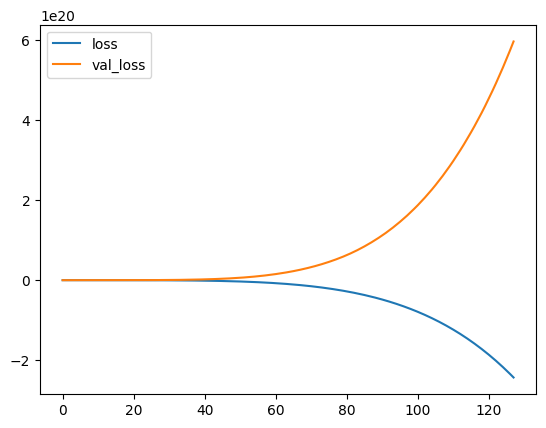

In [9]:
import matplotlib.pyplot as plt
epochs = 128
# batch_size = 262144
batch_size = 2048
validation_split = 0.1
history = nn_model.fit(game_pivot, game_pivot, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

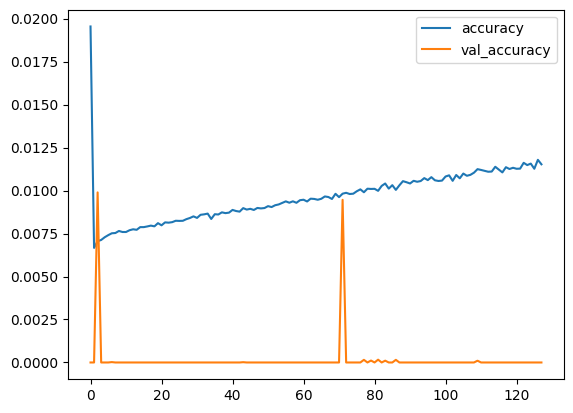

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
